# 1. Get dataset

In [143]:
import pandas as pd

# Correct the path to the file
path = 'World-Stock-Prices-Dataset.csv'  # Ensure this file exists in the current working directory
dataset = pd.read_csv(path)
# Display the first few rows of the DataFrame
print(dataset.head())

                        Date        Open        High         Low       Close  \
0  2025-06-06 00:00:00-04:00    7.010000    7.330000    6.920000    7.300000   
1  2025-06-06 00:00:00-04:00   99.910004  101.529999   99.910004  101.459999   
2  2025-06-06 00:00:00-04:00   71.080002   71.480003   70.940002   71.349998   
3  2025-06-06 00:00:00-04:00  120.930000  121.410004  119.720001  120.500000   
4  2025-06-06 00:00:00-04:00  300.290009  303.500000  299.230011  302.470001   

       Volume  Dividends  Stock Splits             Brand_Name Ticker  \
0  15367100.0        0.0           0.0                peloton   PTON   
1   1091300.0        0.0           0.0                  crocs   CROX   
2   9521800.0        0.0           0.0  the coca-cola company     KO   
3     26600.0        0.0           0.0                 adidas  ADDYY   
4   2099000.0        0.0           0.0       american express    AXP   

      Industry_Tag  Country  Capital Gains  
0          fitness      usa            Na

# 2. Preprocessing

In [144]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Select top tickers with most data ---
min_rows_required = 50  # Tickers must have at least this many rows
top_n = 10              # Number of tickers to use

# Get top tickers with sufficient data
ticker_counts = dataset['Ticker'].value_counts()
selected_tickers = ticker_counts[ticker_counts >= min_rows_required].head(top_n).index.tolist()

print(f"Selected tickers: {selected_tickers}")

# Prepare combined dataset
combined_df = dataset[dataset['Ticker'].isin(selected_tickers)].copy()

# Convert 'Date' to datetime and sort within each ticker
combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df = combined_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# --- Step 2: Build sequences across all selected tickers ---
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
window_size = 7

X_lstm_list, y_lstm_list = [], []
X_lr_list, y_lr_list = [], []

# Process each ticker separately to preserve time series integrity
for ticker in selected_tickers:
    df = combined_df[combined_df['Ticker'] == ticker].copy()

    if len(df) < window_size + 1:
        continue  # Skip short tickers

    # Scale features individually per ticker
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(df[features])
    y_scaled = scaler_y.fit_transform(df[[target]])

    # Create sequences
    def create_lstm_sequences(X, y, window_size):
        return np.array([X[i-window_size:i] for i in range(window_size, len(X))]), \
               np.array([y[i] for i in range(window_size, len(y))])

    def create_flat_sequences(X, y, window_size):
        return np.array([X[i-window_size:i].flatten() for i in range(window_size, len(X))]), \
               np.array([y[i] for i in range(window_size, len(y))])

    X_lstm, y_lstm = create_lstm_sequences(X_scaled, y_scaled, window_size)
    X_lr, y_lr = create_flat_sequences(X_scaled, y_scaled, window_size)

    X_lstm_list.append(X_lstm)
    y_lstm_list.append(y_lstm)
    X_lr_list.append(X_lr)
    y_lr_list.append(y_lr)

# Combine all tickers' data
# Check if the lists are not empty before concatenating
if X_lstm_list and y_lstm_list and X_lr_list and y_lr_list:
    X_lstm = np.vstack(X_lstm_list)
    y_lstm = np.vstack(y_lstm_list)
    X_lr = np.vstack(X_lr_list)
    y_lr = np.vstack(y_lr_list)

    print("✅ Final Shapes:")
    print("LSTM input shape:", X_lstm.shape)
    print("Linear Regression input shape:", X_lr.shape)
else:
    print("❌ No data available for sequences. Please check the dataset and preprocessing steps.")

Selected tickers: ['MAR', 'MMM', 'NVDA', 'AMD', 'SBUX', 'JNJ', 'COST', 'LUV', 'MCD', 'AEO']
✅ Final Shapes:
LSTM input shape: (64391, 7, 4)
Linear Regression input shape: (64391, 28)


# 3. Models

## I. LSTM

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Build the LSTM model ---
model = Sequential()
model.add(LSTM(32, input_shape=(X_lstm.shape[1], X_lstm.shape[2])))  # Reduced units for speed
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# --- Train the model (optimized) ---
history = model.fit(
    X_lstm,
    y_lstm,
    epochs=20,           # Lowered for speed
    batch_size=32,       # Much faster than batch_size=1
    verbose=1
)

# --- Predict on training data ---
predictions = model.predict(X_lstm)

# NOTE: scaler_y here is only correct if you used a single scaler for all tickers.
# If you used one scaler per ticker, skip inverse_transform or use the correct one per prediction.

# Inverse transform (if single scaler_y used globally)
try:
    y_true = scaler_y.inverse_transform(y_lstm)
    y_pred = scaler_y.inverse_transform(predictions)

    # Display predictions
    for actual, predicted in zip(y_true.flatten(), y_pred.flatten()):
        print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

except Exception as e:
    print("Skipping inverse transform — scaler_y may be per-ticker or mismatched.")
    print("Error:", e)


Epoch 1/20


/usr/local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0046
Epoch 2/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.7033e-04
Epoch 3/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2851e-04
Epoch 4/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.2860e-04
Epoch 5/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1299e-04
Epoch 6/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.5343e-05
Epoch 7/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0050e-04
Epoch 8/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.9977e-05
Epoch 9/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.8975e-05
Epoch 10/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 8.3695e-05
Epoch 11/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.6615e-05
Epoch 12/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.9887e-05
Epoch 13/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.8679e-05
Epoch 14/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss:

## II. Linear Regression

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test) without shuffling — keep time order
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr, y_lr, test_size=0.2, shuffle=False
)

# Train the model
lr_model = LinearRegression()
lr_model.fit(X_lr_train, y_lr_train)

# Predict on test set
lr_predictions = lr_model.predict(X_lr_test)

# Inverse scale predictions and true values
y_true_lr = scaler_y.inverse_transform(y_lr_test)
y_pred_lr = scaler_y.inverse_transform(lr_predictions)

# Evaluate
mse = mean_squared_error(y_true_lr, y_pred_lr)
r2 = r2_score(y_true_lr, y_pred_lr)

print(f"Linear Regression Test MSE: {mse:.4f}")
print(f"Linear Regression Test R² Score: {r2:.4f}")

# Show predicted vs actual
for actual, predicted in zip(y_true_lr.flatten(), y_pred_lr.flatten()):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")


Linear Regression Test MSE: 0.0966
Linear Regression Test R² Score: 0.9985
Actual: 18.38, Predicted: 17.91
Actual: 3.31, Predicted: 3.19
Actual: 3.28, Predicted: 3.25
Actual: 3.30, Predicted: 3.28
Actual: 3.23, Predicted: 3.24
Actual: 3.28, Predicted: 3.21
Actual: 3.30, Predicted: 3.26
Actual: 3.20, Predicted: 3.21
Actual: 3.11, Predicted: 3.19
Actual: 3.13, Predicted: 3.13
Actual: 2.88, Predicted: 3.12
Actual: 3.00, Predicted: 2.89
Actual: 2.94, Predicted: 3.01
Actual: 2.98, Predicted: 2.95
Actual: 2.93, Predicted: 3.00
Actual: 2.87, Predicted: 2.95
Actual: 2.84, Predicted: 2.89
Actual: 2.84, Predicted: 2.86
Actual: 2.83, Predicted: 2.84
Actual: 2.92, Predicted: 2.82
Actual: 2.89, Predicted: 2.97
Actual: 2.87, Predicted: 2.90
Actual: 2.83, Predicted: 2.89
Actual: 2.77, Predicted: 2.86
Actual: 2.76, Predicted: 2.76
Actual: 2.74, Predicted: 2.77
Actual: 2.76, Predicted: 2.77
Actual: 2.68, Predicted: 2.76
Actual: 2.67, Predicted: 2.69
Actual: 2.69, Predicted: 2.70
Actual: 2.61, Predicted

# 4.Results

2013/2013 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


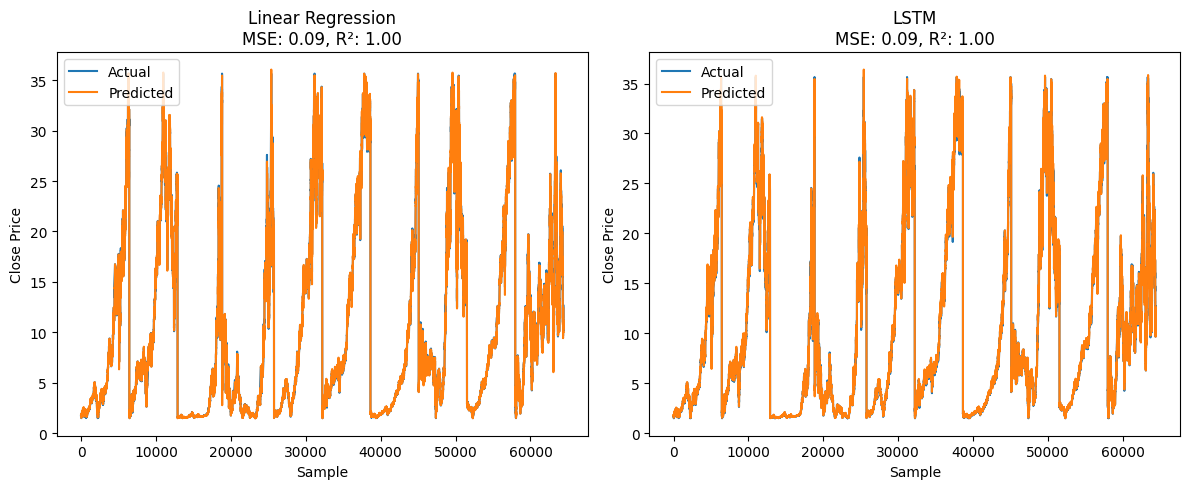

In [147]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ----- Linear Regression Evaluation -----
lr_predictions = lr_model.predict(X_lr)

# Inverse transform
y_true_lr = scaler_y.inverse_transform(y_lr)
y_pred_lr = scaler_y.inverse_transform(lr_predictions)

# Evaluate
mse_lr = mean_squared_error(y_true_lr, y_pred_lr)
r2_lr = r2_score(y_true_lr, y_pred_lr)

# ----- LSTM Evaluation -----
lstm_predictions = model.predict(X_lstm)

# Inverse transform
y_true_lstm = scaler_y.inverse_transform(y_lstm)
y_pred_lstm = scaler_y.inverse_transform(lstm_predictions)

# Evaluate
mse_lstm = mean_squared_error(y_true_lstm, y_pred_lstm)
r2_lstm = r2_score(y_true_lstm, y_pred_lstm)

# ----- Plot Results -----
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
plt.plot(y_true_lr, label='Actual')
plt.plot(y_pred_lr, label='Predicted')
plt.title(f'Linear Regression\nMSE: {mse_lr:.2f}, R²: {r2_lr:.2f}')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()

# LSTM
plt.subplot(1, 2, 2)
plt.plot(y_true_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title(f'LSTM\nMSE: {mse_lstm:.2f}, R²: {r2_lstm:.2f}')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()

plt.tight_layout()
plt.show()
